#  COVID-19 CLASSIFICATION

This data set has x-ray scans labeled into two categories: Covid and Normal

## Labraries

In [1]:
#cv2 used to read images
!pip install opencv-python

You should consider upgrading via the 'C:\Users\rawan\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import cv2 #image I/O, manipulation, and display
import os
import numpy as np #for image stacking
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

#Import the needed modules to create CNN ARCHITECTURE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

#### Global constants


In [3]:
IMG_DIMEN = 224
N_COLOURS = 3

## Reading Dataset

#### First let's check number of classes 

In [4]:
dir_list = sorted(os.listdir('D:/Covid19-dataset/train'))
class_names_lst = [dir_name for dir_name in dir_list]
class_names_lst

['Covid', 'Normal']

#### Showing the differences between our two classes

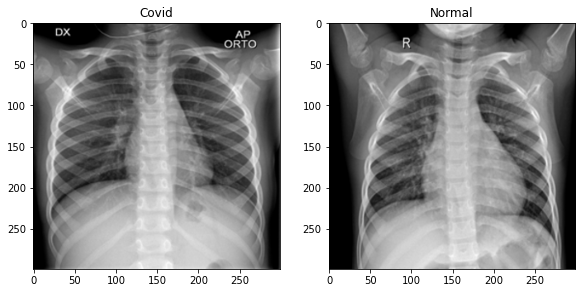

In [5]:
plt.figure(figsize = (15, 15))
covid_img = cv2.imread('D:/Covid19-dataset/train/Covid/COVID-13.png')
normal_img = cv2.imread('D:/Covid19-dataset/train/Normal/Normal-76.png')
plt.subplot(1,3,1)
plt.imshow(covid_img)
plt.title('Covid')
plt.subplot(1,3,2)
plt.imshow(normal_img)
plt.title('Normal')
plt.show()

#### Loading data

In [6]:
#dir_path ->ex: path of train file
def read_data (dir_path):
    x=[] #input
    y=[] #output --> JSON
    y_map ={'Normal' : 0 , 'Covid' : 1 }
    for class_name in y_map.keys():
        #subdir_path -->ex: path of normal file
        subdir_path = os.path.join(dir_path,class_name)
        #filenames --> image name inside each file
        filenames = os.listdir(subdir_path)
        for fname in tqdm(filenames):
            if fname.endswith('.png') or fname.endswith('.jpeg'):
                img_path =  os.path.join(subdir_path,fname)
                img = cv2.imread(img_path)
                #------- Data Preproccessing -------#
                #Scaling image to 224*224
                img = cv2.resize(img,dsize=(IMG_DIMEN,IMG_DIMEN))
                img = img.reshape((1,IMG_DIMEN,IMG_DIMEN,N_COLOURS))
                x.append(img)
                y.append(y_map[class_name])
                
                
    #vstack-> function that helps to stack the input array sequence vertically in order to create a single array
    x = np.vstack(x).astype('float32')/255.0
    y = np.array(y).astype('int32')
    return x , y

In [7]:
x,y = read_data('D:/Covid19-dataset/train')

100%|██████████| 531/531 [00:01<00:00, 509.22it/s]


In [8]:
print(x.shape)
print(y.shape)

(1092, 224, 224, 3)
(1092,)


#### Check balancing in  the data

C:\Users\rawan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

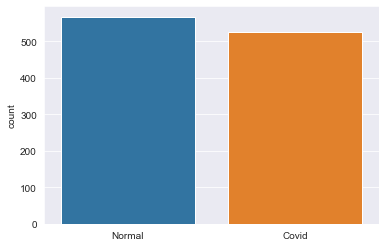

In [9]:
BalancingList = []
for i in y:
    if(i == 0):
        BalancingList.append("Normal")
    else:
        BalancingList.append("Covid")

sns.set_style('darkgrid')
sns.countplot(BalancingList)

The data seems balanced 

In [10]:
x_test,y_test = read_data('D:Covid19-dataset/test')

100%|██████████| 270/270 [00:03<00:00, 81.59it/s] 


#### Splitting data into train and validation

In [11]:
x_train , x_val , y_train , y_val = train_test_split(x,y,test_size=0.33,random_state=0)

## CNN architecture

In [12]:
model = Sequential()
# convolutional layer -> Conv2D
#pooling layer -> MaxPooling2D or AveragePooling2D
#To convert result of multi dimension martix to 1 dimension vector to get final features-> GlobalAveragePooling2D or Flatten
#Dense -> fully connected layer 'last one'

#num of filters = 16 , size of filter : 7*7
model.add(Conv2D(16 , 7 , activation='relu',input_shape=(IMG_DIMEN,IMG_DIMEN,N_COLOURS)))
model.add(Conv2D(16 , 7 , activation='relu'))
#size of filter = 2*2
model.add(MaxPooling2D(2))
model.add(Conv2D(32 ,5 , activation='relu'))
model.add(Conv2D(32 ,5 , activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64 ,3 , activation='relu'))
model.add(Conv2D(64 ,3 , activation='relu'))
model.add(MaxPooling2D(2))
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer = 'adam' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 212, 16)      12560     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 102, 102, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                    

In [13]:
#Define a callback to save the best model according to the loss

checkpoint = ModelCheckpoint('best_model',monitor='val_loss',mode='min',
                             save_weights_only=True,save_best_only=True, verbose=1)

history = model.fit(x_train,y_train ,
                    validation_data = (x_val,y_val) , batch_size=32 , epochs=6 , callbacks=[checkpoint])

Epoch 1/6
23/23 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5349
Epoch 1: val_loss improved from inf to 0.69662, saving model to best_model
23/23 [==============================] - 149s 6s/step - loss: 0.6921 - accuracy: 0.5349 - val_loss: 0.6966 - val_accuracy: 0.4875
Epoch 2/6
23/23 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5349
Epoch 2: val_loss improved from 0.69662 to 0.69335, saving model to best_model
23/23 [==============================] - 141s 6s/step - loss: 0.6911 - accuracy: 0.5349 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 3/6
23/23 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5349
Epoch 3: val_loss improved from 0.69335 to 0.69227, saving model to best_model
23/23 [==============================] - 156s 7s/step - loss: 0.6895 - accuracy: 0.5349 - val_loss: 0.6923 - val_accuracy: 0.4875
Epoch 4/6
23/23 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5349
Epoch

## Virtualizing results

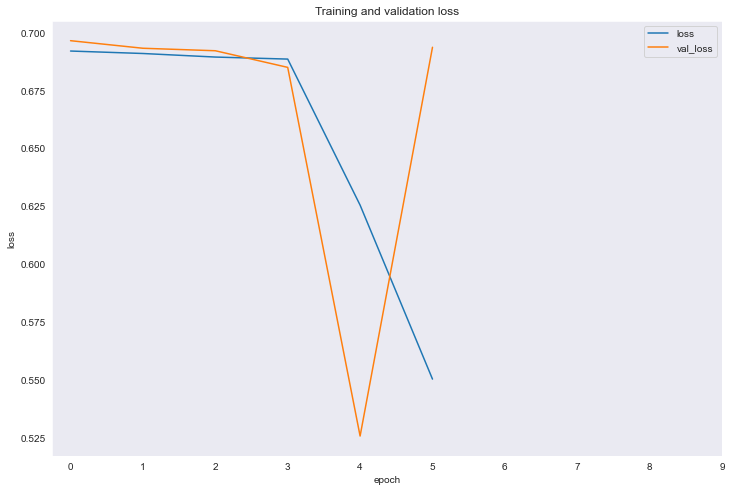

In [14]:
hist_df=pd.DataFrame(history.history)
hist_df.plot(y=['loss' , 'val_loss'] , figsize=(12,8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0,10,1))
plt.show()

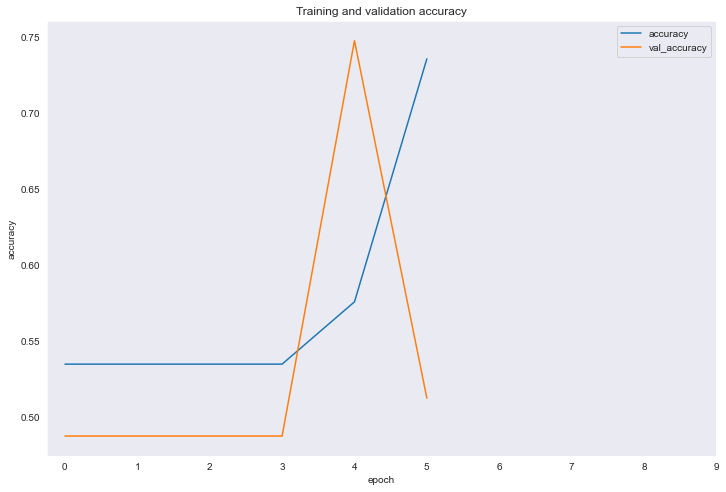

In [15]:
hist_df=pd.DataFrame(history.history)
hist_df.plot(y=['accuracy' , 'val_accuracy'] , figsize=(12,8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0,10,1))
#plt.yticks(np.arange(0.5,1.01,0.05))
plt.show()

## Evaluate Model

In [16]:
model.load_weights('best_model')
model.evaluate(x_test,y_test)

16/16 [==============================] - 6s 394ms/step - loss: 0.6182 - accuracy: 0.6762


[0.6182165145874023, 0.676171064376831]

## End